# Homework 13 


1. Fit a gradient boosting model on the diabetes data
    - Explore various values of the four parameters and find a somewhat optimal model
    - Plot the training loss as a function of iterations
2. Compute and plot the two feature importances: impurity reduction (MDI) and permutation importance (MDA).
3. For the 4 most important features: 
    - plot the partial dependence plots (PDP)
    - plot the ICE curves
    
4. Extra credit: 
    - try a 2D PDP
    - find correlations across the features and discuss "extrapolation"
    

    


In [9]:
#import libraries
import pandas as pd
import numpy as np
#import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score


from sklearn.inspection import  permutation_importance,plot_partial_dependence,PartialDependenceDisplay
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns

**load the Diabetes dataframe**

In [3]:
from sklearn import datasets

diabetes = datasets.load_diabetes()
#X, y = diabetes.data, diabetes.target
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = diabetes.target
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

In [5]:
gbr_params = {"learning_rate" : [0.01, 0.015, 0.02, 0.025, 0.05, 0.75, 0.1],
              #"subsample": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
              "n_estimators": [50, 100, 200, 350, 500, 1000], 
              "max_depth": [1, 2, 3, 4, 5, 7, 10]}

In [6]:
reg = GradientBoostingRegressor(random_state=0)

In [7]:
grid = GridSearchCV(reg, gbr_params, cv = 5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             param_grid={'learning_rate': [0.01, 0.015, 0.02, 0.025, 0.05, 0.75,
                                           0.1],
                         'max_depth': [1, 2, 3, 4, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 350, 500, 1000]})

In [8]:
grid.best_params_
#im not sure whether its smart to actually use a subsample of 0.3 or below, since this 
#increases the bias. therefore the final model will use subsample = 1 instead.

{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50}

In [23]:
gbr_opt = GradientBoostingRegressor(learning_rate = 0.025, 
                                    max_depth =  1, 
                                    n_estimators = 200, 
                                    subsample = 1, 
                                    random_state=0)

gbr_opt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.025, max_depth=1, n_estimators=200,
                          random_state=0, subsample=1)

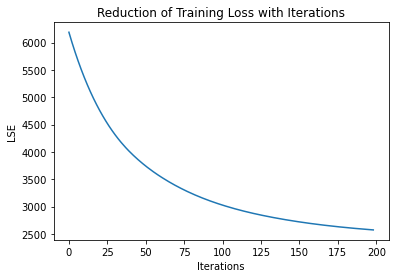

In [147]:
loss_iteration = []
for i in range(199):
    loss_iteration.append(gbr_opt.train_score_[i])

plt.plot(loss_iteration)
plt.xlabel("Iterations")
plt.ylabel("LSE")
plt.title("Reduction of Training Loss with Iterations")
plt.show();

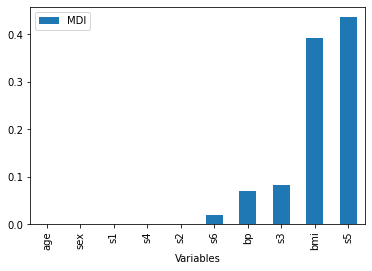

In [146]:
MDI = pd.DataFrame(zip(X_train.columns,gbr_opt.feature_importances_), columns = ["Variables", "MDI"])
MDI.set_index("Variables", inplace = True)
MDI.sort_values("MDI", inplace = True)

MDI.plot(kind = "bar")
plt.show()

Text(0.5, 1.0, 'Barplot of mean permutation importance per variable')

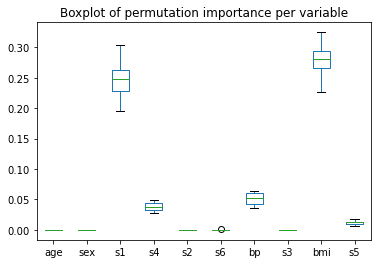

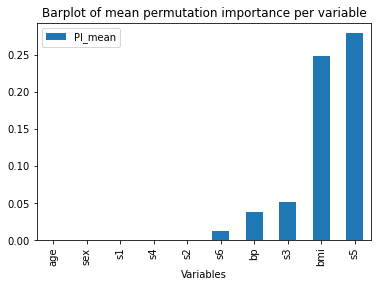

In [145]:
perm_importance = permutation_importance(gbr_opt, X_train, y_train, n_repeats = 20, random_state = 0)
PI = pd.DataFrame(perm_importance.importances).transpose()
PI.columns = MDI.index
PI.boxplot(grid = False)
plt.title("Boxplot of permutation importance per variable")

PI_mean = pd.DataFrame(zip(X_train.columns,perm_importance.importances_mean), columns = ["Variables","PI_mean"])
PI_mean.set_index("Variables", inplace = True)
PI_mean.sort_values("PI_mean", inplace = True)
PI_mean.plot(kind = "bar")
plt.title("Barplot of mean permutation importance per variable")

<Figure size 7200x2160 with 0 Axes>

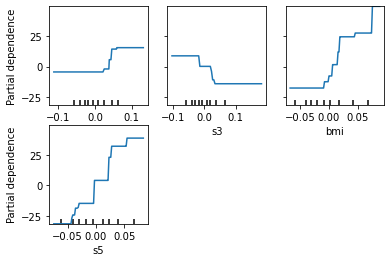

In [150]:
X_top4 = X_train[["bp","s3", "bmi", "s5"]]
plt.figure(figsize=(100,30))
plot_partial_dependence(gbr_opt, X_train, X_top4)  
#this is ugly, but sadly im lacking time atm

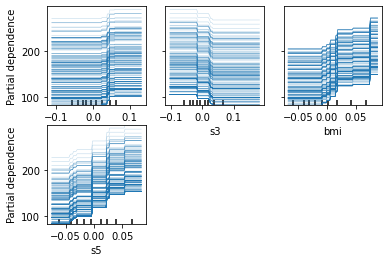

In [154]:
plot_partial_dependence(gbr_opt, X_train, X_top4, kind = "individual")  

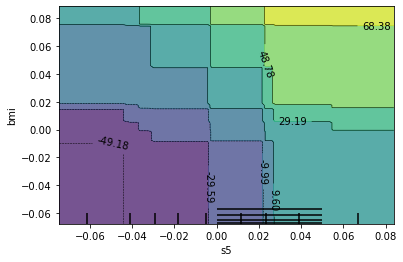

In [158]:
#lets do 2d pdp with top2 features: s5, bmi
plot_partial_dependence(gbr_opt, X_train, [("s5","bmi")])  